### Udacity Data Science Nanodegree
### Project 3: Disaster Recovery Pipeline
---

# Notebook 3 of 3: ML Pipeline Preparation

## by Juanita Smith
---


- [Import libraries and load data from database](#step1)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing](#assessing)
   - [Summary of assessment](#summary_of_assessment)
- [Step 3: Data Cleaning](#clean)
- [Step 4: Save cleaned data](#save)
- [Summary](#summary)
- [References](#references)
- [Submission](#submission)

<a class="anchor" id='step1'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">1. Import libraries and load data from database</span>

In [1]:
import matplotlib.pyplot as plt
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import libraries

from sqlalchemy import create_engine
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, precision_score, fbeta_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from shutil import rmtree

# save and load models
from pickle import dump

# clear the garbage to free memory as we are working with huge datasets
import gc

from openai import OpenAI
import tiktoken
from typing import List
from ast import literal_eval

# CUSTOM models and functions
from src.startingverbtransformer import StartingVerbExtractor
from src.mloversampler import MLOverSampling
from src import config
from src.utils import *

from wordcloud import WordCloud
from collections import Counter
from time import time

import optuna.logging
from optuna.samplers import TPESampler
import logging
import sys

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 300)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# default parameters
random_state = 10
logger = logging.getLogger(__name__)

# activate logging
logging.basicConfig(filename=config.path_log_ml,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w',
                    level=logging.INFO,
                    datefmt='%Y-%m-%d %H:%M:%S')

In [4]:
# load cleaned message data from database
engine = create_engine(config.path_database)
conn = engine.connect()
df = pd.read_sql('select * from messages', con=conn, index_col='id')
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 26179 non-null  object
 1   genre                   26179 non-null  object
 2   related                 26179 non-null  int64 
 3   request                 26179 non-null  int64 
 4   offer                   26179 non-null  int64 
 5   aid_related             26179 non-null  int64 
 6   medical_help            26179 non-null  int64 
 7   medical_products        26179 non-null  int64 
 8   search_and_rescue       26179 non-null  int64 
 9   security                26179 non-null  int64 
 10  military                26179 non-null  int64 
 11  water                   26179 non-null  int64 
 12  food                    26179 non-null  int64 
 13  shelter                 26179 non-null  int64 
 14  clothing                26179 non-null  int64 
 15  money  

In [6]:
# sqlite does not keep data types int8 or category as it's not supported, set it again
df["genre"] = df["genre"].astype("category")
d = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int8)
df = df.astype(d)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   message                 26179 non-null  object  
 1   genre                   26179 non-null  category
 2   related                 26179 non-null  int8    
 3   request                 26179 non-null  int8    
 4   offer                   26179 non-null  int8    
 5   aid_related             26179 non-null  int8    
 6   medical_help            26179 non-null  int8    
 7   medical_products        26179 non-null  int8    
 8   search_and_rescue       26179 non-null  int8    
 9   security                26179 non-null  int8    
 10  military                26179 non-null  int8    
 11  water                   26179 non-null  int8    
 12  food                    26179 non-null  int8    
 13  shelter                 26179 non-null  int8    
 14  clothing                261

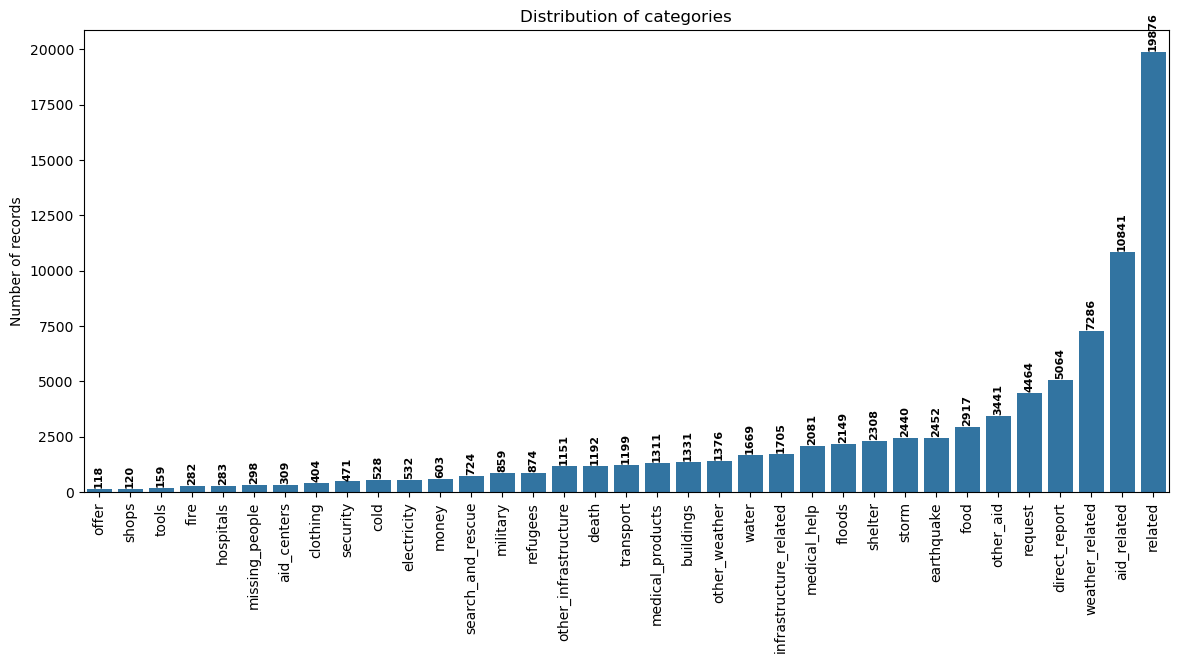

In [7]:
 # plot how categories are distributed
df_sum = df.sum(numeric_only=True).sort_values(ascending=True)
fig = plt.figure(figsize=(14,6))
ax = sns.barplot(data=df_sum)

# annotate
for c in ax.containers:
    # set the bar label based on the y-axis
    ax.bar_label(c, padding=1, fontsize=8, rotation=90, weight='bold')
        
plt.xticks(rotation=90)

plt.title('Distribution of categories')
plt.ylabel('Number of records')
plt.show()

## Prepare data

In [8]:
X = df[['message', 'genre']].copy(deep=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   message  26179 non-null  object  
 1   genre    26179 non-null  category
dtypes: category(1), object(1)
memory usage: 434.7+ KB


In [9]:
# extract labels
y = df.iloc[:, 2:].copy()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   related                 26179 non-null  int8 
 1   request                 26179 non-null  int8 
 2   offer                   26179 non-null  int8 
 3   aid_related             26179 non-null  int8 
 4   medical_help            26179 non-null  int8 
 5   medical_products        26179 non-null  int8 
 6   search_and_rescue       26179 non-null  int8 
 7   security                26179 non-null  int8 
 8   military                26179 non-null  int8 
 9   water                   26179 non-null  int8 
 10  food                    26179 non-null  int8 
 11  shelter                 26179 non-null  int8 
 12  clothing                26179 non-null  int8 
 13  money                   26179 non-null  int8 
 14  missing_people          26179 non-null  int8 
 15  refugees                

### 2. Write a tokenization function to process your text data

In [10]:
# def tokenize(text):
#     
#     # print('Tokenizer triggered')
#     # logger.info('Tokenizer triggered')    
#     
#     # Replace urls starting with 'https' with placeholder
#     url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'    
#     # replace urls with a common keyword
#     detected_urls = re.findall(url_regex, text)
#     for url in detected_urls:
#         text = text.replace(url, 'url')
#         
#     # Replace urls starting with 'www' with placeholder
#     url_regex = 'www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'   
#     detected_urls = re.findall(url_regex, text)
#     for url in detected_urls:
#         text = text.replace(url, 'url')    
# 
#     # replace emails with placeholder   
#     email_regex = '([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})'     
#     detected_emails = re.findall(email_regex, text)
#     for email in detected_emails:
#         text = text.replace(email, 'email')          
#     
#     # replace newlines, which can negatively affect performance.    
#     text = text.replace("\n", " ")
#     text = text.replace("..",".")
#     text = text.replace(". .",".")
#     text = text.replace(" ,.",".")       
#     
#     text = re.sub(r'\s+',  ' ', text).strip()
#         
#     # normalize text by removing punctuation, remove case and strip spaces
#     text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
#     text = text.lower().strip()
#     
#     # remove numbers
#     text = re.sub(r'\d+', '', text)  
#     
# #   split sentence into words
#     tokens = word_tokenize(text)
#     
#     # Remove stopwords, e.g. the, a, 
#     tokens = [w for w in tokens if w not in stopwords.words("english")]    
#     
#     # take words to their core, e.g. children to child, organizations to organization
#     lemmatizer = WordNetLemmatizer()
#     clean_tokens = []
#     for tok in tokens:
#         clean_tok = lemmatizer.lemmatize(tok, wordnet.VERB)
#         # ignore tokens that have only 1 character or contains numbers
#         if len(clean_tok) >= 2 & clean_tok.isalpha():
#             clean_tokens.append(clean_tok)          
# 
#     return clean_tokens
# 
# def normalize_text(text):
#     """ Perform some light data cleaning by removing redundant whitespace and cleaning up the punctuation to prepare the data for embedding."""
#     # print('Tokenizer triggered')
#     # logger.info('Tokenizer triggered')    
#     
#     # Replace urls starting with 'https' with placeholder
#     url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'    
#     # replace urls with a common keyword
#     detected_urls = re.findall(url_regex, text)
#     for url in detected_urls:
#         text = text.replace(url, 'url')
#         
#     # Replace urls starting with 'www' with placeholder
#     url_regex = 'www.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'   
#     detected_urls = re.findall(url_regex, text)
#     for url in detected_urls:
#         text = text.replace(url, 'url')    
#         
#     # replace emails with placeholder   
#     email_regex = '([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})'     
#     detected_emails = re.findall(email_regex, text)
#     for email in detected_emails:
#         text = text.replace(email, 'email')     
#     
#     # replace newlines, which can negatively affect performance.    
#     text = text.replace("\n", " ")
#     text = text.replace("..",".")
#     text = text.replace(". .",".")
#     text = text.replace(" ,.",".")    
#     
#     text = re.sub(r'\s+',  ' ', text).strip()
# 
#     return text

In [11]:
# testing tokenizer
test = df[(df['offer'] == 1)]
# test = df[(df['offer'] == 1) & (df['message_new'].str.contains('www'))][:3]
# test = df[df['message_new'].str.contains('zrcs')][:10]
for message in test['message'][:3]:
    print(message)
    tokens_full = tokenize(message)
    tokens_basic = tokenizer_light(message)
    print(tokens_full)
    print(tokens_basic, '\n')

I am a driver, a mechanic ,. I want to help
['driver', 'mechanic', 'want', 'help']
I am a driver, a mechanic. I want to help 

How can we help the victims at Les Cayes?
['help', 'victims', 'les', 'cayes']
How can we help the victims at Les Cayes? 

I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave
['vice', 'president', 'association', 'rafadek', 'anse', 'galets', 'call', 'could', 'help', 'people', 'la', 'gonave']
I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave 



In [12]:
def word_cloud(counter, title=None, max_words=20):  
    """produces two wordcloud based on key phrases and 
    key adjectives extracted from each neighborhood descriptions
    inputs:
        - neighborhood name (string)
        - list of key phrases (list of strings)
        - list of adjectives (list of strings)
    outputs:
        - two worldclouds
    """
            
    f, ax = plt.subplots()
    cloud = WordCloud( 
                        background_color = 'white',
                        width=2500, height=1800, max_words=max_words,
                        ).generate_from_frequencies(frequencies=counter)
    ax.imshow(cloud)
    ax.axis('off')
    plt.title(title, fontsize=30, backgroundcolor= 'silver')
    plt.show()

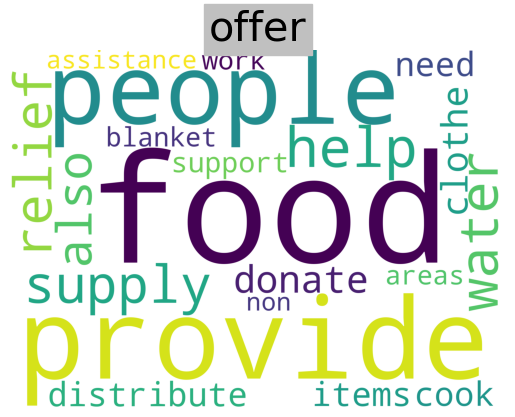

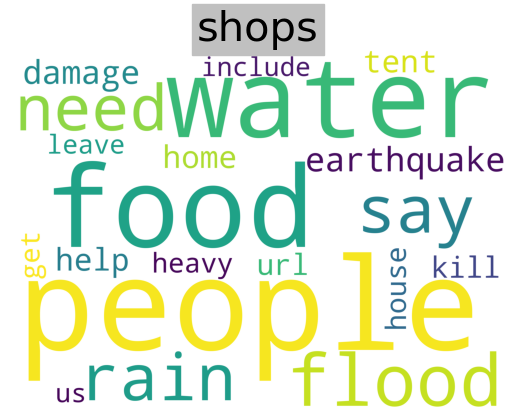

In [13]:
categories = ['offer', 'shops']

def cat_plot(categories, df):

    cv = CountVectorizer(tokenizer=tokenize,
                         token_pattern=None,
                         min_df=3,
                         max_df=0.9,
                         max_features=8000,
                         ngram_range=(1,1),
                         )

    for cat in categories:

         df_cat = df[df[cat] == 1]

         tokens = cv.fit_transform(df_cat['message'])
        
         # get word headings
         feature_names = cv.get_feature_names_out()
        
         freq = pd.DataFrame(tokens.toarray().sum(axis=0))
         freq.columns = ['count']
         freq.index = feature_names
         freq = freq.sort_values(by='count', ascending=False)
        
         freq_dict = freq['count'].to_dict()
         word_cloud(freq_dict, cat)

cat_plot(categories, df)

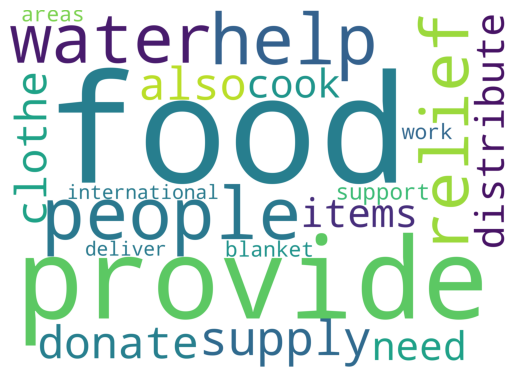

In [14]:

counter=Counter()
[counter.update(tokenize(m)) for m in test.message]
counter.most_common(20)
word_cloud(counter)

In [15]:
# quick lemmitizer test
from nltk.corpus import wordnet
words = ['provide', 'provided', 'providing', 'house', 'houses', 'housing']
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(word) for word in words] )
print([lemmatizer.lemmatize(word, wordnet.VERB) for word in words])

['provide', 'provided', 'providing', 'house', 'house', 'housing']
['provide', 'provide', 'provide', 'house', 'house', 'house']


In [16]:
# # Build a custom transformer which will extract the starting verb of a sentence
# class StartingVerbExtractor2(BaseEstimator, TransformerMixin):
#     """
#     Starting Verb Extractor class
# 
#     This class create a new boolean feature indicating of a sentence start with a verb or not
#     
#     Args:
#         X -> dataframe: can have multiple columns
#         col -> string: column in the data dataframe that contains the text to be searched
#         
#     Returns:
#         df -> return a new dataset with a new BOOLEAN column called 'starting_verb'
#     """
# 
#     def starting_verb(self, text):
#         sentence_list = nltk.sent_tokenize(text)
# 
#         for sentence in sentence_list:
#             pos_tags = nltk.pos_tag(tokenize(sentence))
#             if len(pos_tags) > 0:
#                 first_word, first_tag = pos_tags[0]
#                 if first_tag in ['VB', 'VBP', 'VBN', 'VBG'] or first_word == 'RT':
#                     return True
#         return False
# 
#     def fit(self, X, y=None):
#         # Given it is a transformer we can return the self 
#         return self
# 
#     def transform(self, X, col='message_new'):
#         X_tagged = X[col].apply(self.starting_verb)        
#         df = pd.DataFrame(X_tagged)
#         df.columns = ['starting_verb']
#         return df

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

As the dataset is imbalanced we need to split the data in the same proportions as the actual labels
We will use iterative stratification:
  - as the labelsets are large, 
  - works well with binary relevance
  - handles rare labels in a better way and most important, 
  - maintains the imbalance ratio of each label in each subset
    
**Note**: it is not possible to use multioutput and xgboost with callbacks or early stop for multi label, it is not supported if in a pipeline.

In [17]:
# split data into test, validation and test datasets, whilst using stratification
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_train_split(X, y, random_state=random_state)

Total records: X(26179, 2):y(26179, 35)
Train shape: X(17452, 2):y(17452, 35)
Validation shape: X(4363, 2):y(4363, 35)
Test shape: X(4364, 2):y(4364, 35)


In [18]:
# make sure data type 'category' is kept
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17452 entries, 2 to 30262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   message  17452 non-null  object  
 1   genre    17452 non-null  category
dtypes: category(1), object(1)
memory usage: 289.9+ KB


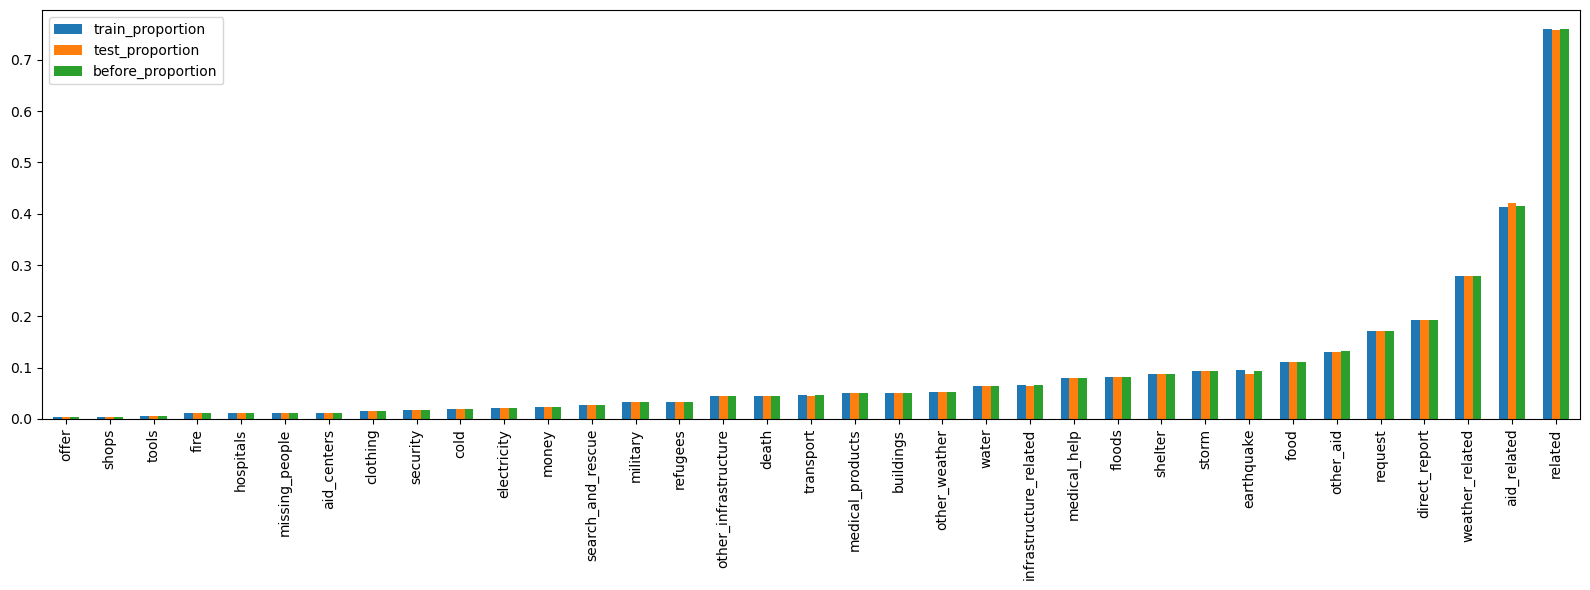

In [19]:
# make sure proportions are the same for original y, test and train datasets due to stratified split
plot_label_proportions(y, y_train, y_test)

> Label were split in the same proportions between train, validation and test datasets

In [20]:
# Oversample the minority classes
# ml_sampler = MLOverSampling()
# print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
# X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
# print('Training shapes after: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

# Augment the minority classes
ml_sampler = MLOverSampling()
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.augment_text(X_train, y_train)
print('Training shapes after: {} {}'.format(X_train_sub.shape, y_train_sub.shape)) 

Training shapes before: (17452, 2) (17452, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1395, 2) (1395, 35)
Training shapes after: (30815, 2) (30815, 35)


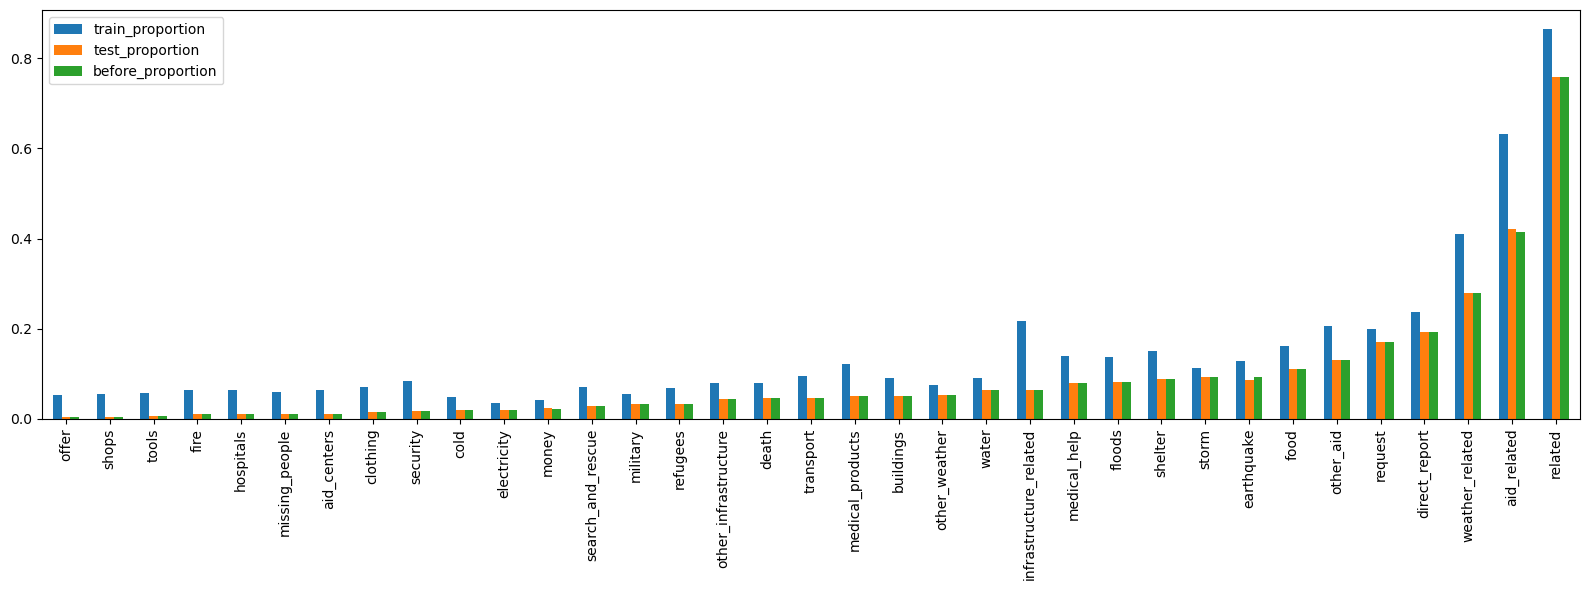

In [21]:
plot_label_proportions(y, y_train_sub, y_test)

In [22]:
# to handle imbalance, calculate a global scale_pos_weight, which are total negative / total positive responses
# pos = y_train[y_train == 1].count().sum()
# neg = y_train[y_train == 0].count().sum()
# pos_weight = np.sqrt(neg / pos)
# pos_weight

In [23]:
from scipy.misc import derivative


class Focal_Binary_Loss:
    """
    The class of focal loss, allows the users to change the gamma parameter
    
    This class was taken directly from GitHub of the python package that implements it.
    I'm not interested in using the package - just the loss function to see if it works better with imbalanced datasets
    https://github.com/jhwjhw0123/Imbalance-XGBoost
    """

    def __init__(self, gamma_indct):
        '''
        :param gamma_indct: The parameter to specify the gamma indicator
        '''
        self.gamma_indct = gamma_indct
        logger.info('\nFocal loss initialization triggered...')

    def robust_pow(self, num_base, num_pow):
        # numpy does not permit negative numbers to fractional power
        # use this to perform the power algorithmic

        return np.sign(num_base) * (np.abs(num_base)) ** (num_pow)

    def focal_binary_object(self, pred, dtrain):
        logger.info('\nFocal loss calculation triggered...')
        print('\nFocal loss calculation triggered...')
        gamma_indct = self.gamma_indct
        # retrieve data from dtrain matrix
        label = dtrain.get_label()
        # compute the prediction with sigmoid
        sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
        # gradient
        # complex gradient with different parts
        g1 = sigmoid_pred * (1 - sigmoid_pred)
        g2 = label + ((-1) ** label) * sigmoid_pred
        g3 = sigmoid_pred + label - 1
        g4 = 1 - label - ((-1) ** label) * sigmoid_pred
        g5 = label + ((-1) ** label) * sigmoid_pred
        # combine the gradient
        grad = gamma_indct * g3 * self.robust_pow(g2, gamma_indct) * np.log(g4 + 1e-9) + \
               ((-1) ** label) * self.robust_pow(g5, (gamma_indct + 1))
        # combine the gradient parts to get hessian components
        hess_1 = self.robust_pow(g2, gamma_indct) + \
                 gamma_indct * ((-1) ** label) * g3 * self.robust_pow(g2, (gamma_indct - 1))
        hess_2 = ((-1) ** label) * g3 * self.robust_pow(g2, gamma_indct) / g4
        # get the final 2nd order derivative
        hess = ((hess_1 * np.log(g4 + 1e-9) - hess_2) * gamma_indct +
                (gamma_indct + 1) * self.robust_pow(g5, gamma_indct)) * g1
        logger.info('Gradiant: {}, Hess: {}'.format(grad, hess))
        return grad, hess
    
def custom_loss(y_pred, y_true, alpha=0.25, gamma=2):
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess
    

In [24]:
xgb.set_config(verbosity=3)

# cache transformers so they are only executed once, especially during gridsearch
cachedir = '../cache'
# memory = Memory(location=cachedir, verbose=10)

focal_loss = Focal_Binary_Loss(gamma_indct = 2.5)

# using defaults of XGBOOST
params = {
    # 'objective': 'binary:logistic',    
    'objective': 'binary:logitraw',
    # 'objective': focal_loss_new(alpha=0.25, gamma=2),
    'n_jobs': -1,
    'max_depth': 12,
    'min_child_weight': 1.4,
    'gamma': 0.64,
    # 'eval_metric': 'map', # error, error@0.5 mlogloss, mae, auc, map, aucpr, logloss
    # 'eval_metric': 'aucpr',
    'eval_metric': focal_loss.focal_binary_object,
    'booster': 'gbtree',   
    'n_estimators': 100,
    'colsample_bytree': 1, # default is 1,
    'subsample': 0.9, # default is 1
    'tree_method': 'hist', # exact, approx, auto, hist
    'scale_pos_weight': 1,
    'max_delta_step': 15.5, # default is None
    'reg_lambda': 0.004, # lambda
    'reg_alpha': 0.003, # alpha
    'learning_rate': 0.4,
    'verbosity': 3,
    # 'num_round': 10,
    'random_state' : random_state,
    # one_hot_encoding support is not compatible with column transformer which return an array
    # 'enable_categorical': True,
    # 'max_cat_to_onehot': 5,
    'multi_strategy':"one_output_per_tree",  
}

text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if word appears in less than 3 documents ignore it
                             max_df=0.90, # remove too frequent words in 90% of documents
                             max_features=10000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=True)

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('text_vect', text_nlp, 'message'),
    ('one_hot', OneHotEncoder(), ['genre']),    
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
# train classifier
# label_ratio = ml_sampler.get_sample_ratio(y_train)
# sample_weights = calculate_sample_weights(label_ratio, y_train, power=1)
# pipeline_base.fit(X_train, y_train, clf__sample_weight=sample_weights)
# pipeline_base.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

In [ ]:
# Evaluate results
y_pred_val, score_base = evaluate(X_val, y_val, pipeline_base, zero_division=0)
auc_base = print_results(y_val, y_pred_val)

In [ ]:
accuracy = (y_pred_val == y_val).mean().mean()
accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sens_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train_sub)

In [ ]:
X_train_transformed.shape

In [ ]:
d_train = xgb.DMatrix(X_train_transformed, label=y_train_sub)

In [ ]:
# focal_loss = Focal_Binary_Loss(gamma_indct = 2.5)
# grad, hess = focal_loss.focal_binary_object(pred=y_pred_val, dtrain=d_train)
grad, hess = custom_loss(y_pred_val, y_val, alpha=0.25, gamma=2)

In [ ]:
hess

In [ ]:
# get idea of model complexity
dump_list = pipeline_base.named_steps['clf'].get_booster().get_dump()
num_trees = len(dump_list)
print('Number of trees {}'.format(num_trees))

In [ ]:
import graphviz 
from xgboost import plot_tree
from xgboost import plot_importance

def visualize_tree(xgb, bst, tree_to_plot=0):
    """ Visualize tree for XGBoost model

    # gain: the average gain across all splits the feature is used in.
    # weight: the number of times a feature is used to split the data across all trees.
    # cover: the average coverage across all splits the feature is used in.
    # total_gain: the total gain across all splits the feature is used in.
    # total_cover: the total coverage across all splits the feature is used in.
    """

    tree_to_plot = tree_to_plot
    # plot_tree(bst, fmap='../data/models/xgb.fmap', num_trees=tree_to_plot, rankdir='LR')
    plot_tree(bst, num_trees=tree_to_plot, rankdir='LR')    

    fig = plt.gcf()

    # Get current size
    fig_size = fig.get_size_inches()

    # Set zoom factor
    sizefactor = 20

    # Modify the current size by the factor
    plt.gcf().set_size_inches(sizefactor * fig_size)

    # The plots can be hard to read (known issue). So, separately save it to a PNG, which makes for easier viewing.
    # fig.savefig('tree' + str(tree_to_plot)+'.png')
    plt.show()

In [ ]:
# model = pipeline_base.named_steps['clf'],
# visualize_tree(xgb, pipeline_base.named_steps['clf'], tree_to_plot=1)

In [ ]:
# use cross-validation to find the best gamma value for focal loss function

def get_xgb_perf(model, X, y):
    # preds = (model.predict(X_val) >= 0.5) * 1
    preds = model.predict(X)
    return precision_score(y, preds, average='micro'), accuracy_score(y, preds)


def focal_loss_new(alpha, gamma):
    def custom_loss(y_pred, y_true):
        a,g = alpha, gamma
        def fl(x,t):
            p = 1/(1+np.exp(-x))
            return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
        partial_fl = lambda x: fl(x, y_true)
        grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
        hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
        return grad, hess
    return custom_loss

xgb_results = {}

# train_d_matrix = xgb.DMatrix(X_train, label = y_train)
# test_d_matrix = xgb.DMatrix(X_val, label = y_val)

for idx, gamma in enumerate([0.0001, 100]):
    # focal_loss = Focal_Binary_Loss(gamma_indct = gamma)
    # params['objective']: focal_loss.focal_binary_object
    print('\nGamma {} starting...'.format(gamma))
    params['objective']: focal_loss_new(alpha=0.25, gamma=gamma)
    # grad, hess = focal_loss.focal_binary_object(pipeline_base.predict(train_d_matrix),train_d_matrix)
    
    pipeline_base = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', xgb.XGBClassifier(**params)),    
    ],
        memory=cachedir,
        verbose=True,
    )
    
    model_focal = pipeline_base.fit(X_train_sub, y_train_sub)

    xgb_f1, xbg_acc = get_xgb_perf(model_focal, X_val, y_val)
    xgb_results[f'focal-{gamma}'] = {'f1' : xgb_f1, 'acc': xbg_acc}
    print('Gamma {} results\n'.format(gamma))
    print(xgb_results[f'focal-{gamma}'])

### 6. Improve your model with GridSearch
Use grid search to find better parameters. 

Scoring to consider for imbalance is: f1_micro, f1_weighted, roc_auc, auc
Set parameter max_delta_step to a finite number (say 1) to help convergence

[Click here to see XGBOOST documenation how to handle Imbalance](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

In [ ]:
# scoring = 'f1_micro'
# scoring = 'precision'
verbose = 1

# scoring = make_scorer(precision_score, average = 'samples', zero_division=0) 
# scoring = make_scorer(precision_score, average = 'weighted', zero_division=0)

# when we want to treat all classes in the same way, weighted is like macro but considers imbalance
scoring = make_scorer(precision_score, average = 'macro', zero_division=0)

# when we want to give preference to higher classes
# scoring = make_scorer(precision_score, average = 'micro', zero_division=0)
# try also samples
# sample_weights = calculate_sample_weights(label_ratio, y_train_sub, power=1)


In [ ]:
## Try Bayes_Optimzation
def objective(trial):

    # param = {
    #     "verbosity": 0,
    #     "objective": "binary:logistic",
    #     # use exact for small dataset.
    #     "tree_method": "exact",
    #     # defines booster, gblinear for linear functions.
    #     "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
    #     # L2 regularization weight.
    #     "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
    #     # L1 regularization weight.
    #     "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    #     # sampling ratio for training data.
    #     "subsample": trial.suggest_float("subsample", 0.2, 1.0),
    #     # sampling according to each tree.
    #     "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    # }
    # 
    # if param["booster"] in ["gbtree", "dart"]:
    #     # maximum depth of the tree, signifies complexity of the tree.
    #     param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    #     # minimum child weight, larger the term more conservative the tree.
    #     param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    #     param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    #     # defines how selective algorithm is.
    #     param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    #     param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    # 
    # if param["booster"] == "dart":
    #     param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    #     param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    #     param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    #     param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    param = {        
        # 'clf__n_estimators': trial.suggest_int('clf__n_estimators', low=50, high=200, step=50),
        # 'clf__scale_pos_weight': trial.suggest_float('clf__scale_pos_weight', low=1, high=20),    
        'clf__max_delta_step': trial.suggest_float('clf__max_delta_step', low=0.0001, high=100),             
        'clf__max_depth': trial.suggest_int('clf__max_depth', low=2, high=15, step=1),
        'clf__reg_lambda': trial.suggest_float('clf__reg_lambda', low=0.01, high=100), 
        'clf__gamma': trial.suggest_float('clf__gamma', low=0.01, high=100),
        'clf__min_child_weight': trial.suggest_float('clf__min_child_weight', low=1, high=100),     
        'clf__reg_alpha': trial.suggest_float('clf__reg_alpha', low=0.01, high=100),  
        'clf__learning_rate': trial.suggest_float('clf__learning_rate', low=0.01, high=100),
    }

    # y_pred = pipeline_base.predict(X_val)
    # precision = precision_score(y_val, y_pred, average='macro')
    # auc = roc_auc_score(y_val, y_pred)
    
    # scoring = make_scorer(precision_score, average = 'macro', zero_division=0)    
    # scoring = make_scorer(fbeta_score, beta=0.5, average = 'macro', zero_division=0)  
    # scoring = make_scorer(roc_auc_score, average = 'macro')
    # scoring_new = make_scorer(average_precision_score, average='macro')

    pipeline_base.set_params(**param)
    
    score = cross_val_score(estimator=pipeline_base,
                             X=X_train_sub, 
                             y=y_train_sub, 
                             scoring=scoring,
                             cv=MultilabelStratifiedKFold(n_splits=3,
                                                           shuffle=True,
                                                           random_state=random_state),
                             # n_jobs=-1
                            ).mean()
    
    return score


# Add stream handler of stdout to show the messages
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
# study_name = "example-study"  # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name)

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.
study = optuna.create_study(sampler=TPESampler(), direction="maximize")

logger.info("START OPTUNA OPTIMIZATION...")
study.optimize(objective, n_trials=200)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
rmtree(cachedir)

In [ ]:
print(f"---Bayesian Optimization---")
print(f"Number of iterations: {len(study.trials)}")
print(f"Best trial index: {study.best_trial.number}")
print(f"Best score: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_params}")

In [ ]:
# weighted results with focal = 20
# ---Bayesian Optimization---
# Total time: 13467.05 seconds
# Number of iterations: 100
# Best trial index: 56
# Best score: 0.6632930695211856
# Best hyperparameters: {'clf__max_delta_step': 68.33327592270413, 'clf__max_depth': 17, 'clf__reg_lambda': 0.8013306864519425, 'clf__gamma': 94.74950056962814, 'clf__min_child_weight': 5.251142785200699, 'clf__reg_alpha': 1.152076136247572, 'clf__learning_rate': 92.78139589552919}

# precision when using macro
# --Bayesian Optimization---
# Total time: 13567.09 seconds
# Number of iterations: 100
# Best trial index: 78
# Best score: 0.638201818062178
# Best hyperparameters: {'clf__max_delta_step': 96.77005332190778, 'clf__max_depth': 3, 'clf__reg_lambda': 0.030954575737015766, 'clf__gamma': 71.73715118987855, 'clf__min_child_weight': 9.95871322295499, 'clf__reg_alpha': 2.1910311179698647, 'clf__learning_rate': 82.68098545851105}

# --Bayesian Optimization---
# Total time: 16079.85 seconds
# Number of iterations: 100
# Best trial index: 81
# Best score: 0.8561057932336551
# Best hyperparameters: {'clf__max_delta_step': 0.3837680141712284, 'clf__max_depth': 3, 'clf__reg_lambda': 94.66407437605135, 'clf__gamma': 10.623917596969811, 'clf__min_child_weight': 22.96825511444155, 'clf__reg_alpha': 19.24187252664213, 'clf__learning_rate': 1.7881549290644685}

# micro avg       0.75      0.56      0.64     13815
#              macro avg       0.56      0.31      0.38     13815
#           weighted avg       0.71      0.56      0.60     13815
#            samples avg       0.64      0.50      0.51     13815
# 
# AUC aggregate: 0.6374260861951391

# micro, focal 2.5, very bad results
# ---Bayesian Optimization---
# Total time: 15069.92 seconds
# Number of iterations: 100
# Best trial index: 51
# Best score: 0.8263367477633932
# Best hyperparameters: {'clf__max_delta_step': 0.06526405959267022, 'clf__max_depth': 7, 'clf__reg_lambda': 10.883341699269685, 'clf__gamma': 28.55018699887786, 'clf__min_child_weight': 13.416098290852586, 'clf__reg_alpha': 81.69036029082243, 'clf__learning_rate': 58.84558003566277}

#              micro avg       0.74      0.17      0.28     13815
#              macro avg       0.43      0.19      0.24     13815
#           weighted avg       0.47      0.17      0.24     13815
#            samples avg       0.31      0.12      0.16     13815
# 
# AUC aggregate: 0.5907602090107461

# scoring roc_auc with focal loss 2.5
# Params: 
#     clf__max_delta_step: 62.85902705959377
#     clf__max_depth: 10
#     clf__reg_lambda: 39.930335232797034
#     clf__gamma: 35.16591598665951
#     clf__min_child_weight: 17.256676990298402
#     clf__reg_alpha: 0.05247616991496429
#     clf__learning_rate: 76.0341467592735


# 
# Params: 
#     clf__max_delta_step: 48.35834324434542
#     clf__max_depth: 9
#     clf__reg_lambda: 0.5024367927053275
#     clf__gamma: 86.4882157545091
#     clf__min_child_weight: 1.5192890522922653
#     clf__reg_alpha: 0.019789740499815106
#     clf__learning_rate: 97.86458336746098


In [ ]:
# test = study.trials_dataframe()
# # test.to_csv('../data/study_results.csv')
# test

In [ ]:
# fig = plt.figure(figsize=(20,6))
# sns.lineplot(data=test, x='params_clf__gamma', y='value', label='max step')
# sns.lineplot(data=test, x='params_clf__max_depth', y='value', label='max depth')
# plt.show()

In [ ]:
# Total time: 606621.41 seconds
# Number of iterations: 200
# Best trial index: 199
# Best score: 0.9442869274831933
# Best hyperparameters: {'clf__n_estimators': 100, 'clf__scale_pos_weight': 1.0099199883180554, 'clf__max_delta_step': 15.540279512814008, 'clf__max_depth': 12, 'clf__reg_lambda': 0.0038376550609826978, 'clf__gamma': 0.6399466245757152, 'clf__min_child_weight': 1.3322310688472614, 'clf__reg_alpha': 0.003113428583080456, 'clf__learning_rate': 0.038001681926279306}

In [ ]:
pipeline_base.set_params(**study.best_params)
# pipeline_base['clf'].get_params()
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score2 = evaluate(X_val, y_val, pipeline_base)
auc_2 = print_results(y_val, y_pred_val)

In [ ]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, score2=score2, score3=None, score1_name='base', score2_name='pos_weight', score3_name=None)

In [ ]:
# auc score, came to 71.2 but poor 
#       micro avg       0.46      0.81      0.58     13815
#              macro avg       0.37      0.55      0.44     13815
#           weighted avg       0.51      0.81      0.61     13815
#            samples avg       0.42      0.67      0.47     13815

# Best hyperparameters: {'clf__n_estimators': 150, 'clf__scale_pos_weight': 15.312350363689909, 'clf__max_delta_step': 19.308026920713157, 'clf__max_depth': 7, 'clf__reg_lambda': 0.8393669062781971, 'clf__gamma': 0.2757782725590271, 'clf__min_child_weight': 9.793355968118075, 'clf__reg_alpha': 0.05350879464634534, 'clf__learning_rate': 0.2632068449568947}

## Step 2 - Tune pos_weight

Controlling Imbalance

Balancing of positive and negative weights to handle imbalance

In [ ]:
hyperparameters = {
    'clf__scale_pos_weight' : [1, 1.3, 1.5, 2, 2.5],
    # 'clf__max_delta_step' : [None, 1, 3],    
}

gridsearch2 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state)

rmtree(cachedir)

In [ ]:
# param_pos_weight = {'clf__scale_pos_weight': 2}
# full_pipeline.set_params(**param_pos_weight)
# full_pipeline['clf'].get_params()

In [ ]:
# Update model parameters with cross validation results
pipeline_base.set_params(**gridsearch2.best_params_)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score2 = evaluate(X_val, y_val, pipeline_base)
auc_2 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score2, score3=None, score1_name='base', score2_name='pos_weight', score3_name=None)

In [ ]:
cv_plot_scores(gridsearch2)

In [ ]:
print('Base AUC = {}, grid search AUC = {}'.format(auc_base, auc_2))

## Step 3 - Grid search for max depth and min child weight

Control over fitting and model complexity

### max depth

In [ ]:
hyperparameters = {
    'clf__max_depth' : [5, 6, 7, 8],
}

gridsearch3 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
# Update model parameters with cross validation results
pipeline_base.set_params(**gridsearch3.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score3 = evaluate(X_val, y_val, pipeline_base)
auc_3 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score2, score3=score3, score1_name='base', score2_name='pos_weight', score3_name='max_depth')

In [ ]:
cv_plot_scores(gridsearch3)

### min child weight

In [ ]:
hyperparameters = {
    'clf__min_child_weight': [1, 1.5, 2, 2.5, 3]
}

gridsearch4 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
# Update model parameters with cross validation rsults
pipeline_base.set_params(**gridsearch4.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score4 = evaluate(X_val, y_val, pipeline_base)
auc_4 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score3, score3=score4, score1_name='base', score2_name='gamma', score3_name='min_child_weight')

In [ ]:
print('Base AUC = {}\npos_weight search AUC = {}\nmin_child_weight AUC = {}\n'.format(auc_base, auc_2, auc_4))

In [ ]:
# Best Parameters: {'clf__max_depth': 12, 'clf__min_child_weight': 1}

In [ ]:
cv_plot_scores(gridsearch4)

## Step 4 - Tune Gamma

In [ ]:
hyperparameters = {
    'clf__gamma': [0.1, 1, 2],
}

gridsearch5 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

pipeline_base.set_params(**gridsearch5.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score5 = evaluate(X_val, y_val, pipeline_base)
auc_5 = print_results(y_val, y_pred_val, pipeline_base)
cv_plot_scores(gridsearch5)

In [ ]:
plot_scores(score1=score_base, score2=score5, score3=None, score1_name='base', score2_name='gamma', score3_name=None)

In [ ]:
# samples
plot_scores(score1=score_base, score2=score5, score3=None, score1_name='base', score2_name='gamma', score3_name=None)

In [ ]:
# SAMPLES
# micro avg       0.73      0.63      0.67     13792
#              macro avg       0.54      0.38      0.43     13792
#           weighted avg       0.69      0.63      0.64     13792
#            samples avg       0.63      0.55      0.54     13792

# MICRO
# micro avg       0.73      0.63      0.67     13792
#              macro avg       0.54      0.38      0.43     13792
#           weighted avg       0.69      0.63      0.64     13792
#            samples avg       0.63      0.55      0.54     13792


# WEIGHTED

In [ ]:
print('Base AUC = {}\npos_weight AUC = {}\nmin_child_weight AUC = {}\ngamma AUC = {}\n'.format(auc_base, auc_2, auc_4, auc_5))

In [ ]:
# Best Parameters: {'clf__gamma': 1}

## Step 5 - Tune lambda (L2 regularization)
Stops over fitting

In [ ]:
hyperparameters = {
    # 'clf__lambda': [0.01, 0.01, 0.1, 0.5, 1],  
    'clf__reg_lambda': [0.01, 0.1, 0.5, 1],      
}

gridsearch6 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
pipeline_base.set_params(**gridsearch6.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val,  score6 = evaluate(X_val, y_val, pipeline_base)
auc_6 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score5, score3=score6, score1_name='base', score2_name='gamma', score3_name='lambda')

In [ ]:
cv_plot_scores(gridsearch6)

## Step 6 - Tune alpha  (L1 regularization)
Stops over fitting

In [ ]:
hyperparameters = {
    # 'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],   
    'clf__reg_alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],       
}

gridsearch7 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
pipeline_base.set_params(**gridsearch7.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val,  score7 = evaluate(X_val, y_val, pipeline_base)
auc_7 = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score6, score3=score7, score1_name='base', score2_name='lambda', score3_name='alpha')

In [ ]:
cv_plot_scores(gridsearch7)

## Step 7 - Tune learning rate

In [ ]:
hyperparameters = {
    'clf__learning_rate': [0.001, 0.1, 0.2, 0.3, 0.4],    
}

gridsearch8 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            label_ratio=None,
                            calc_sample_ratio=False,
                            )

rmtree(cachedir)

In [ ]:
pipeline_base.set_params(**gridsearch8.best_params_)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val,  score8 = evaluate(X_val, y_val, pipeline_base)
auc_8 = print_results(y_val, y_pred_val, pipeline_base)


In [ ]:
plot_scores(score1=score_base, score2=score7, score3=score8, score1_name='base', score2_name='alpha', score3_name='learning_rate')

In [ ]:
cv_plot_scores(gridsearch8)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
# update parameters with grid search results

params_new = params

for key, value in gridsearch2.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch3.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch4.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch5.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch6.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch7.best_params_.items():
    params_new[key[5:]] = value

for key, value in gridsearch8.best_params_.items():
    params_new[key[5:]] = value

# params_new['max_depth'] = 5
params_new

#### 8.1 Try to use OPENAI to create embeddings instaed of tokenizer

Verify inputs don't exceed the maximum length

The maximum length of input text for our latest embedding models is 8192 tokens. You should verify that your inputs don't exceed this limit before making a request.
If sending an array of inputs in a single embedding request the max array size is 2048.

In [ ]:
df_embeddings = df.copy(deep=True)
df_embeddings.head()

In [ ]:
# Setting the API key to use OPEN AI models
openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key, max_retries=5)

# default openai settings
embedding_model = "text-embedding-3-large"
# embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [ ]:
def get_embeddings(
    list_of_text: List[str], model="text-embedding-3-small", **kwargs
) -> List[List[float]]:
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."
   
   # clean up the text just a little bit 
    list_of_text =[normalize_text(text) for text in list_of_text]

    # text_embedding_3_large model brings back always 3072 dimensions
    data = client.embeddings.create(input=list_of_text,
                                    model=model, 
                                    encoding_format="float",
                                    dimensions=1000,
                                    **kwargs).data
    return [d.embedding for d in data]

In [ ]:
# how many tokens do we have ?  
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df_embeddings["n_tokens"] = df_embeddings.message_new.apply(lambda x: len(encoding.encode(x)))

print('Total tokens is {}'.format(df_embeddings["n_tokens"].sum()))
print('Longest token is {}'.format(df_embeddings["n_tokens"].max()))

In [ ]:
# for how many records is token value 0 or too small ?
print('Number of records with too small tokens is {}'.format(
    len(df_embeddings[df_embeddings['n_tokens'] < 2])))

# get index of those records with too small tokens
idx = df_embeddings[df_embeddings['n_tokens'] < 2].index

# drop those records with too small tokens
df_embeddings = df_embeddings.drop(idx, axis=0)

In [ ]:
# only 50000 tokens can be processed at a time. As we have over 800k tokens, we need to process them in batch

records = df_embeddings[['message_new']].to_dict("records")
print("Records to process: ", len(records))
product_vectors = []
docs = []
batchsize = 2000

for idx,doc in enumerate(records,start=1):
    # create byte vectors
    docs.append(doc["message_new"])
    if idx % batchsize == 0:
        product_vectors += get_embeddings(docs, embedding_model)
        docs.clear()
        print("Vectors processed ", len(product_vectors), end='\r')
        
product_vectors += get_embeddings(docs, embedding_model)
print("Vectors processed ", len(product_vectors), end='\r')

In [ ]:
# add embedding back to dataframe and save
df_embeddings['embedding'] = product_vectors
df_embeddings.head()

In [ ]:
# write to csv file
df_embeddings.to_csv("../data/openai_embedding_dim1000.csv")

In [ ]:
# update database with embeddings dataset
# df_embeddings.to_sql('embeddings', engine, index=True, if_exists='replace')

In [ ]:
# load back saved embeddings
# df_embeddings_new = pd.read_sql('select * from embeddings', con=conn, index_col='id')
# df_embeddings_new.head()

In [ ]:
# To load the data from a saved file, you can run the following:
df_embeddings = pd.read_csv("../data/openai_embedding_dim1000.csv", index_col=0)

In [ ]:
df_embeddings['embedding'] = df_embeddings.embedding.apply(literal_eval).apply(np.array)
df_embeddings.head()

In [ ]:
X = df_embeddings[['embedding', 'genre', 'message_new']].copy()
X.head()

# df_embeddings.embedding.values

In [ ]:
# extract labels
y = df_embeddings.iloc[:, 2:-5].copy()
y.head()

In [ ]:
# split data into train, validation and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_train_split(
    X, y, random_state=random_state)
X_train[:10]

In [ ]:
# Oversample the minority classes
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

In [ ]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = '../cache'

# params_new['max_depth'] = 10

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),      
    ('starting_verb', StartingVerbExtractor(), 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='passthrough',
    verbose=True,
)

# preprocessor = Pipeline([
#     ('feature_union', FeatureUnion([
# 
#         ('starting_verb', StartingVerbExtractor()),
#         ('text_processing', preprocessor),
# ],
#         verbose=True, 
# ))])


pipeline_embedding = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
clf = xgb.XGBClassifier(**params_new)  

In [ ]:
# sample_weights = calculate_sample_weights(label_ratio, y_train_sub, power=1)
pipeline_embedding.fit(list(X_train_sub.embedding), y_train_sub)
# clf.fit(list(X_train_sub.embedding), y_train_sub, sample_weight=sample_weights)

In [ ]:
y_pred_val = evaluate(list(X_val.embedding), y_val, clf)

In [ ]:
print_results(y_val, y_pred_val, clf)

In [ ]:
# # Build a custom transformer which will extract the starting verb of a sentence
# class EmbeddingTransformer(BaseEstimator, TransformerMixin):
#     """
#     Starting Verb Extractor class
# 
#     This class extract the starting verb of a sentence,
#     creating a new feature for the ML classifier
#     """    
#     
#     from itertools import chain
#     
#     def fit(self, X, y=None):
#         # Given it is a transformer we can return the self 
#         return self
# 
#     def transform(self, X):
#         X_new = pd.DataFrame([[v for lst in arr for v in lst] for arr in X.values])
#         return X_new
    

In [ ]:
# X_new = pd.DataFrame([[v for lst in arr for v in lst] for arr in X.values])
# X_new.shape

#### 8.2 using another tree method

In [ ]:
params_new['multi_strategy']: 'multi_output_tree'
clf = xgb.XGBClassifier(**params_new)  

# clf.fit(list(X_train_sub.embedding), y_train_sub, sample_weight=sample_weights)
# clf.fit(list(X_train_sub.embedding), y_train_sub)
clf.fit(X_train_sub, y_train_sub)

In [ ]:
y_pred_val = evaluate(list(X_val.embedding), y_val, clf)

In [ ]:
print_results(y_val, y_pred_val, clf)

#### 8.2 Add new feature 'starting_verb'

In [ ]:
# # Build a custom transformer which will extract the starting verb of a sentence
# class StartingVerbExtractor2(BaseEstimator, TransformerMixin):
#     """
#     Starting Verb Extractor class
# 
#     This class extract the starting verb of a sentence,
#     creating a new feature for the ML classifier
#     """
# 
#     def starting_verb(self, text):
#         sentence_list = nltk.sent_tokenize(text)
# 
#         for sentence in sentence_list:
#             pos_tags = nltk.pos_tag(tokenize(sentence))
#             if len(pos_tags) > 0:
#                 first_word, first_tag = pos_tags[0]
#                 if first_tag in ['VB', 'VBP', 'VBN', 'VBG'] or first_word == 'RT':
#                     return True
#         return False
# 
#     def fit(self, X, y=None):
#         # Given it is a transformer we can return the self 
#         return self
# 
#     def transform(self, X):
#         # print(X['message_new'][:5])
#         # apply starting_verb function to all values in X
#         # X_tagged = pd.Series(X['message_new']).apply(self.starting_verb)
#         X_tagged = X['message_new'].apply(self.starting_verb)        
#         # # return pd.DataFrame(X_tagged, columns=['starting_verb'])
#         df = pd.DataFrame(X_tagged)
#         df.columns = ['verb']
#         return df
    

# test the new function    
verb = StartingVerbExtractor()
print(X_train['message_new'].head(5))
testing = verb.fit_transform(X_train[:5])
testing

In [ ]:
# cache transformers so they are only executed once, especially during gridsearch
cachedir = '../cache'

# params_new['max_depth'] = 10

text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if word appears in less than 3 documents ignore it
                             max_df=0.90, # remove too frequent words in 80% of documents
                             max_features=8000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=True)

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']),      
    ('text_vect', text_nlp, 'message_new'),
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

preprocessor = Pipeline([
    ('feature_union', FeatureUnion([

        ('starting_verb', StartingVerbExtractor()),
        ('text_processing', preprocessor),
],
        verbose=True, 
))])


pipeline_starting_verb = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
# train classifier
# label_ratio = get_sample_ratio(y_train)
# sample_weights = calculate_sample_weights(label_ratio, y_train_sub, power=1)
# full_pipeline.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_starting_verb.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

In [ ]:
y_pred_val,  score_verb = evaluate(X_val, y_val, pipeline_starting_verb)
auc_verb = print_results(y_val, y_pred_val, pipeline_base)

In [ ]:
plot_scores(score1=score_base, score2=score8, score3=score_verb, score1_name='base', score2_name='cv', score3_name='starting_verb')

In [ ]:
print('Base AUC = {}\nAfter cross validation AUC = {}\nAdding verb AUC = {}\n'.format(auc_base, auc_8, auc_verb))

### 9. Export your model as a pickle file

In [ ]:
# save fitted models

dump(pipeline_base, open('../models/model_f1_micro.pkl', 'wb'))

### 10. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

https://cookbook.openai.com/examples/batch_processing

https://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label

https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat

https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote

[Oversampling](https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification)

[Creating Balanced Multi-Label Datasets for Model Training and Evaluation](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)


[MLSMOTE for MoA](https://www.kaggle.com/code/yassinealouini/mlsmote-for-moa)

[Creating balanced multilabel datasets comparing multiple libraries](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

[xgboost for LLMS](https://www.kaggle.com/code/vbmokin/llm-20-feature-xgboost-after-deobfuscation/notebook

[How to use xgboost multi label](https://xgboost.readthedocs.io/en/latest/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py)

[XGBOOST is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook)

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost

[Mastering XGBoost Parameters Tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

[Nested pipelines](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c)

[Using predefined split during cross validation](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)

[Using GridSearchCV to validate against validation dataset](https://stackoverflow.com/questions/46815252/using-scikit-learn-gridsearchcv-for-cross-validation-with-predefinedsplit-susp)

[Plotting training vs validation cross validation scores](https://www.kaggle.com/code/willcanniford/predicting-back-pain-with-sklearn-and-gridsearchcv)

[Early stopping](https://stackoverflow.com/questions/78178902/is-there-example-of-xgb-xgbregressor-with-callbacks-early-stop-early-stop-xgb)

[XGBOOST Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

[Evalution metrics for cross valdation](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001)

[Optima demo](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)
[Bayes_optimazation demo - faster than GridSearchCV](https://www.dailydoseofds.com/bayesian-optimization-for-hyperparameter-tuning/)

[Focal loss with XGBOOST](https://www.kaggle.com/code/kriskriskris/imbalanced-data-practice)

[precision-recall curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
[Focal loss with XGBClassier](https://datascience.stackexchange.com/questions/74780/how-to-implement-custom-loss-function-that-has-more-parameters-with-xgbclassifie)

[text augmentation using SynonymAug](https://medium.com/@ka.kaewnoparat/the-power-of-stopword-removal-and-data-augmentation-for-imbalanced-classes-in-multi-label-61444ba8dacd)

clf__estimator__max_delta_step=3, clf__estimator__scale_pos_weight=30; 
Best Parameters: {'clf__estimator__max_depth': 15, 'clf__estimator__min_child_weight': 4}
Best Parameters: {'clf__estimator__gamma': 10}
Best Parameters: {'clf__estimator__colsample_bytree': 0.9, 'clf__estimator__subsample': 0.7}

